# Generative models; Generative Adversarial Networks 

[link](https://arxiv.org/pdf/1701.00160.pdf)

<b>Generative Adversarial Networks</b> (GANs) are another category of the generative models we will talk about. But before we start we must discuss the differences between GANs and other generative neural networks.
        
Traditional generative neural networks are build on the principle of <b>Maximum Likelihood Estimation</b>. We are training model to generate data $x$ based on the latent variables $z$:

$$\theta^* = \underset{\theta}{\operatorname{argmax}} \sum_{i=1}^n \log p_{model}(x_i|z;\theta)$$

Usually we are trying to minimize the difference between the empirical probability and the a priori one, induced by the model:

$$q_{\phi}^* = \underset{\phi}{\operatorname{argmin}}d_{KL}(p(x)||p_{model}(x|z))$$

The biggest drawback of this solution is the fact that we must introduce some assumptions about the data distribution, they might be incorrect and decrease the quality of the results.


GANs are implicit density models; we do not need to assume anything about the probability distribution. In order to achieve that we are training the model indirectly; instead of comparing the results with a given probability distribution we are simultaneously training two networks: <b>Generator</b>, which generates new observation based on the latent variables $\tilde{x} = G(Z;\theta)$ and <b>Discriminator</b> $D(x,\tilde{x};\psi)$, which learns to distinguish real input $x$ from the generated one $\tilde{x}$ and asses the quality of the Generator output.

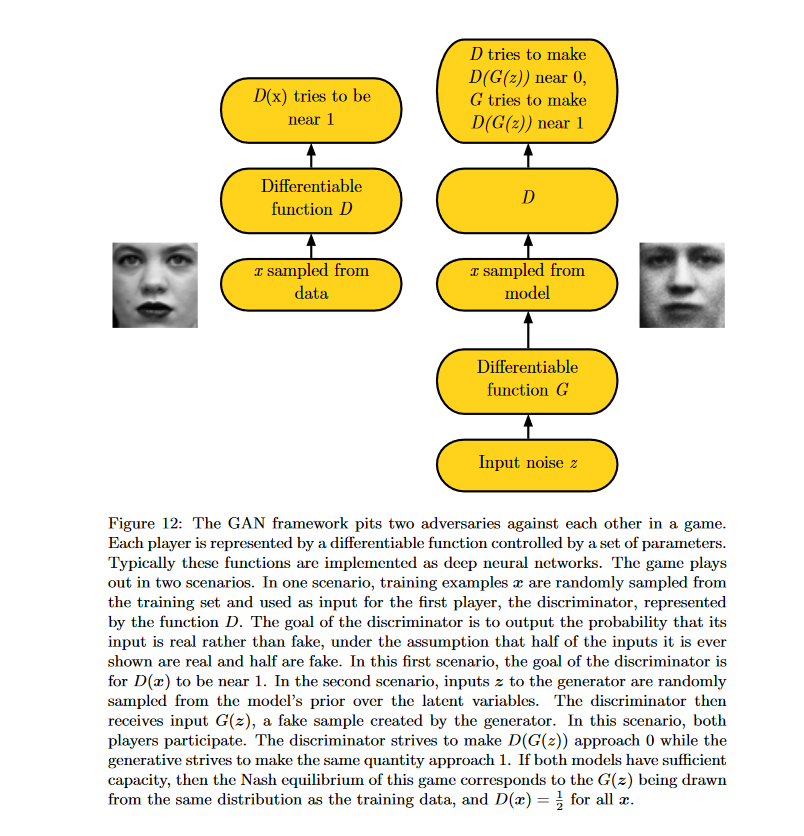

GANs have many advantages over explicit density generative models:

- Generated output (e.g. pictures) have visibly higher quality.
- GANs requires less assumptions to work; we do not need assume any probability distributions families or use Markov chains.
- As a result GANs are able to learn much more complicated probability distributions.
- GANs are de facto semi-supervised - discriminator is trained to to classify the data, thus it could be used to other learning tasks.

With a modified approach we must also calculate the loss function differently.

Discriminator loss is a standard cross-entropy between the real input and data generated by the generator model:

$$ J_D(\theta,\psi) =- E_{x \sim p_{data}}\log D(x) -E_z \log (1 - D(G(z)) $$

But Generator loss is non-trivial. Generative Adversarial Networks could (and should) be analized in the game theory terms. The goal of the Discriminator is to lern to distinguish between the real and fake input. On the other hand, Generator is trained to deceive the Discriminator, so his loss is equal to:

$$J_G(\theta,\psi) = - J_D(\theta, \psi)$$

As a result we get the two players  <b>zero-sum game</b>. We  can  summarize  the  entire  game with a utility function specifying the Discriminator’s payoff: $U(\theta,\psi) = - J_D(\theta, \psi)$.

Optimal solution is a <b>Nash equilibrium</b> and it could be find by the J. von Neumann's <b>Minimax theorem</b>:

$$\theta^* = \underset{\theta}{\operatorname{argmin}} \underset{\psi}{\operatorname{max}}U(\theta,\psi)$$

From the probability theory perspective, this equlibrium is equivalent to the minimization of the Jensen-Shannon divergence.

But this approach introduce many possible problems - finding an equilibrium (which is a saddle point!) is much harder than optimizing the regular loss function. It results in many specific issues:
- Non-convergence is a serious issue; e.g. if Discrimiator learns to perfectly reject all the generated input, then Generator's gradient will vanish and we will not be able to train the model properly.
- Because we must coordinate the training of two networks at the same time GANs often seem to oscillate; improvement of Generator's loss might significantly decrease the quality of Discriminator and vice versa.
- Often Generator learns to map several different input values to the same output, which is known as <b>mode collapse</b> or <b>Helvetica scenario</b>.

To partially avoid these issues we could modify the loss function of the Generator:

- Instead of minimizing the log-probability  of  the discriminator  being  correct we could   maximize the  log-probability of the discriminator being mistaken.
- We could rewrite it in the Maximum Likelihood Estimation terms.

Other visible issues with GANs is the lack of the interpretability and lack of proper evaluation tools and techniques.

Let show some example:

In [1]:
using Flux, MLDatasets.MNIST
using Flux: mse, throttle, params, Statistics, @epochs
using Base.Iterators: partition
using Printf, BSON, LinearAlgebra
using Zygote
using Images
using CUDA

In [2]:
use_cuda = true

true

In [3]:
 if use_cuda && CUDA.functional()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

┌ Info: Training on GPU
└ @ Main In[3]:3


In [4]:
batch_size = 128
latent_dim = 100

100

In [5]:
train_imgs, train_labels = MNIST.traindata(Float32);

In [6]:
Y = Float32.(Flux.onehotbatch(train_labels, 0:9)) |> device;

In [7]:
imgs = reshape(@.(2f0 * train_imgs - 1f0), 28, 28, 1, :);

In [8]:
data = [(imgs[:,:,:,i], Y[:,i]) for i in partition(1:size(imgs,4), batch_size)] |> device;

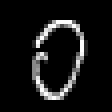

In [9]:
Gray.(dropdims((cpu(data[3][1][:,:,:,5]).+1.f0) ./ 2.f0; dims = 3))

In [10]:
d_labels = Chain(Dense(10,28^2), x-> reshape(x, 28, 28, 1, size(x, 2))) |> device
d_common = Chain(Conv((3,3), 2=>128, pad=(1,1), stride=(2,2)),
                  x-> leakyrelu.(x, 0.2f0),
                  Dropout(0.4),
                  Conv((3,3), 128=>128, pad=(1,1), stride=(2,2), leakyrelu),
                  x-> leakyrelu.(x, 0.2f0),
                  x-> reshape(x, :, size(x, 4)),
                  Dropout(0.4),
                  Dense(6272, 1)) |> device

Chain(
  Conv((3, 3), 2 => 128, pad=1, stride=2),  # 2_432 parameters
  var"#5#8"(),
  Dropout(0.4),
  Conv((3, 3), 128 => 128, leakyrelu, pad=1, stride=2),  # 147_584 parameters
  var"#6#9"(),
  var"#7#10"(),
  Dropout(0.4),
  Dense(6272, 1),                       # 6_273 parameters
)                   # Total: 6 arrays, 156_289 parameters, 1.258 KiB.

In [11]:
function discriminator(label, data)
    x = cat(d_labels(label), data, dims=3)
    return d_common(x)
end

discriminator (generic function with 1 method)

In [12]:
g_labels = Chain(Dense(10, 49), x-> reshape(x, 7 , 7 , 1 , size(x, 2))) |> device
g_latent = Chain(Dense(latent_dim, 6272), x-> leakyrelu.(x, 0.2f0), x-> reshape(x, 7, 7, 128, size(x, 2))) |> device
g_common = Chain(ConvTranspose((4, 4), 129=>128; stride=2, pad=1),
            BatchNorm(128, leakyrelu),
            Dropout(0.25),
            ConvTranspose((4, 4), 128=>64; stride=2, pad=1),
            BatchNorm(64, leakyrelu),
            Conv((7, 7), 64=>1, tanh; stride=1, pad=3)) |> device

Chain(
  ConvTranspose((4, 4), 129 => 128, pad=1, stride=2),  # 264_320 parameters
  BatchNorm(128, leakyrelu),            # 256 parameters, plus 256
  Dropout(0.25),
  ConvTranspose((4, 4), 128 => 64, pad=1, stride=2),  # 131_136 parameters
  BatchNorm(64, leakyrelu),             # 128 parameters, plus 128
  Conv((7, 7), 64 => 1, tanh, pad=3),   # 3_137 parameters
)         # Total: 10 trainable arrays, 398_977 parameters,
          # plus 4 non-trainable, 384 parameters, summarysize 2.562 KiB.

In [13]:
function generator(labels, noise)
    x = cat(g_labels(labels), g_latent(noise), dims=3)
    return g_common(x)
end

generator (generic function with 1 method)

In [14]:
function discriminator_loss(real_output, fake_output)
    real_loss = Flux.Losses.logitbinarycrossentropy(real_output, 1f0)
    fake_loss = Flux.Losses.logitbinarycrossentropy(fake_output, 0f0)
    return (real_loss + fake_loss)
end

generator_loss(fake_output) = Flux.Losses.logitbinarycrossentropy(fake_output, 1f0)

generator_loss (generic function with 1 method)

In [15]:
function sample(noise, labels)
    @eval Flux.istraining() = false
    imgs = @.(generator(device(labels), device(noise)))
    @eval Flux.istraining() = true
    imgs = cpu(imgs)
    Gray.((transpose(dropdims(reduce(vcat, reduce.(hcat, partition(imgs, 4))); dims=(3, 4)))
            .+ 1f0)./2.f0)
end

sample (generic function with 1 method)

In [16]:
opt_dscr = ADAM(0.0002, (0.5, 0.99))
opt_gen = ADAM(0.0002, (0.5, 0.99))

ADAM(0.0002, (0.5, 0.99), 1.0e-8, IdDict{Any, Any}())

In [17]:
function train_discriminator(fake_data, fake_labels, original_data, labels, opt_discr)
    ps = params(d_labels, d_common)
    loss, back = Zygote.pullback(ps) do
        discriminator_loss(discriminator(labels, original_data), discriminator(fake_labels, fake_data))
    end
    grads = back(1f0)
    Flux.Optimise.update!(opt_discr, ps, grads)
    return loss
end

Zygote.@nograd train_discriminator

4×4 Matrix{Int64}:
 8  1  4  9
 2  2  8  0
 0  7  9  3
 8  1  4  2

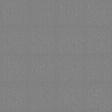

4×4 Matrix{Int64}:
 8  1  4  9
 2  2  8  0
 0  7  9  3
 8  1  4  2

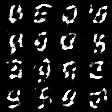

4×4 Matrix{Int64}:
 8  1  4  9
 2  2  8  0
 0  7  9  3
 8  1  4  2

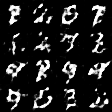

4×4 Matrix{Int64}:
 8  1  4  9
 2  2  8  0
 0  7  9  3
 8  1  4  2

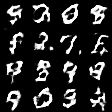

4×4 Matrix{Int64}:
 8  1  4  9
 2  2  8  0
 0  7  9  3
 8  1  4  2

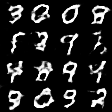

4×4 Matrix{Int64}:
 8  1  4  9
 2  2  8  0
 0  7  9  3
 8  1  4  2

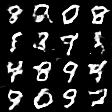

4×4 Matrix{Int64}:
 8  1  4  9
 2  2  8  0
 0  7  9  3
 8  1  4  2

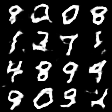

4×4 Matrix{Int64}:
 8  1  4  9
 2  2  8  0
 0  7  9  3
 8  1  4  2

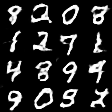

4×4 Matrix{Int64}:
 8  1  4  9
 2  2  8  0
 0  7  9  3
 8  1  4  2

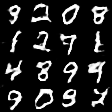

4×4 Matrix{Int64}:
 8  1  4  9
 2  2  8  0
 0  7  9  3
 8  1  4  2

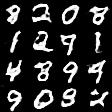

┌ Info: Beginning training loop...
└ @ Main In[18]:3
┌ Info: Epoch 1
└ @ Main In[18]:6
┌ Info: Epoch: 1, Discriminator loss = 1.2934883, Generator loss = 0.7378723
└ @ Main In[18]:21
┌ Info: Epoch 2
└ @ Main In[18]:6
┌ Info: Epoch: 2, Discriminator loss = 1.2591377, Generator loss = 0.82421374
└ @ Main In[18]:21
┌ Info: Epoch 3
└ @ Main In[18]:6
┌ Info: Epoch: 3, Discriminator loss = 1.1485702, Generator loss = 0.88204527
└ @ Main In[18]:21
┌ Info: Epoch 4
└ @ Main In[18]:6
┌ Info: Epoch: 4, Discriminator loss = 1.140598, Generator loss = 0.9635331
└ @ Main In[18]:21
┌ Info: Epoch 5
└ @ Main In[18]:6
┌ Info: Epoch: 5, Discriminator loss = 1.1924694, Generator loss = 0.8476311
└ @ Main In[18]:21
┌ Info: Epoch 6
└ @ Main In[18]:6
┌ Info: Epoch: 6, Discriminator loss = 1.2940207, Generator loss = 0.76575327
└ @ Main In[18]:21
┌ Info: Epoch 7
└ @ Main In[18]:6
┌ Info: Epoch: 7, Discriminator loss = 1.2499964, Generator loss = 0.6675408
└ @ Main In[18]:21
┌ Info: Epoch 8
└ @ Main In[18]:6
┌

In [18]:
noise = [randn(Float32,latent_dim, 1) for i=1:16] 
labels = [float32.(Flux.onehotbatch(rand(0:9, 1), 0:9)) for i =1:16];
@info("Beginning training loop...")
for epoch = 1:10
    d_loss,g_loss = Inf, Inf
    @info "Epoch $epoch"
    display(reduce(vcat, reduce.(hcat, partition(Flux.onecold.(labels), 4))) .- 1)
    display(sample(noise,labels))
    for (x, labels) in data
        latents = randn(Float32,(latent_dim, batch_size)) |> device
        y = Float32.(Flux.onehotbatch(rand(0:9, batch_size), 0:9)) |> device
        ps = params(g_labels, g_latent, g_common)
        g_loss, back = Zygote.pullback(ps) do
            fake = generator(y, latents)
            d_loss = train_discriminator(fake, y, x, labels, opt_dscr)
            generator_loss(discriminator(y, fake))
        end
        grads = back(1f0)
        Flux.Optimise.update!(opt_gen, ps, grads)
    end
    @info("Epoch: $epoch, Discriminator loss = $d_loss, Generator loss = $g_loss")
    BSON.@save "CDGAN_MNIST.bson" d_labels d_common g_labels g_latent g_common
end

In [19]:
BSON.@load "CDGAN_MNIST.bson" d_labels d_common g_labels g_latent g_common

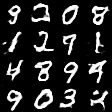

In [20]:
display(sample(noise,labels))

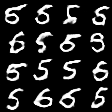

In [21]:
noise = [randn(Float32,latent_dim, 1) for i=1:16]
labels = [float32.(Flux.onehotbatch(5, 0:9)) for i =1:16];
display(sample(noise,labels))